In [1]:
# Import necessary Python libraries
import hashlib
import time
from collections import defaultdict
import random
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define classes for managing transactions and blocks
class Transaction:
    def __init__(self, sender, recipient, amount):
        self.sender = sender
        self.recipient = recipient
        self.amount = amount
    
    def to_dict(self):
        return {
            'sender': self.sender,
            'recipient': self.recipient,
            'amount': self.amount,
        }

        
class Block:
    def __init__(self, index, previous_hash, transactions, timestamp, proof):
        self.index = index
        self.previous_hash = previous_hash
        self.transactions = transactions
        self.timestamp = timestamp
        self.proof = proof

    def calculate_hash(self):
        return hashlib.sha256(f"{self.index}{self.previous_hash}{self.transactions}{self.timestamp}{self.proof}".encode()).hexdigest()


In [3]:
# Define a Blockchain class for managing blockchain system.
class Blockchain:
    def __init__(self):
        self.chain = []
        self.current_transactions = []
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    @staticmethod
    def hash(block):
        return block.calculate_hash()

    def last_block(self):
        return self.chain[-1] if self.chain else None


In [4]:
# Define a Proof-of-Work consensus mechanism and transaction verification function.
class PoWConsensus:
    @staticmethod
    def proof_of_work(last_proof, difficulty=6):
        proof = 0
        while PoWConsensus.validate_proof(last_proof, proof, difficulty) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, difficulty=6):
        guess = f"{last_proof}{proof}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:difficulty] == "0" * difficulty


def verify_transaction(transaction):
    if 'sender' not in transaction or 'recipient' not in transaction or 'amount' not in transaction:
        return False  

    sender = transaction['sender']
    recipient = transaction['recipient']
    amount = transaction['amount']

    return True  

In [5]:
# Define Proof-of-Stake (PoS) consensus mechanism and associated blockchain functions.
class PoSConsensus:
    def __init__(self):
        self.validators = []
        self.chain = []
        self.current_transactions = []
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    def add_validator(self, validator):
        self.validators.append(validator)

    def select_validator(self):
        return random.choice(self.validators)

    def proof_of_stake(self, last_block):
        validator = self.select_validator()
        proof = 0
        while self.validate_proof(last_block.proof, proof, validator) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, validator):
        guess = f"{last_proof}{proof}{validator}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:4] == "0000"

    def last_block(self):
        return self.chain[-1] if self.chain else None

    def get_previous_hash(self, last_block):
        return self.hash(last_block)

    @staticmethod
    def hash(block):
        block_string = json.dumps(block.__dict__, sort_keys=True, default=lambda x: x.to_dict())
        return hashlib.sha256(block_string.encode()).hexdigest()

In [6]:
# Define a Delegated Proof-of-Stake (DPoS) consensus mechanism and associated blockchain functions.
class DPoSConsensus:
    def __init__(self):
        self.delegates = []
        self.chain = []
        self.current_transactions = []
        self.votes = {}  
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    def add_delegate(self, delegate):
        self.delegates.append(delegate)
        self.votes[delegate] = []  

    def select_delegate(self):
        return random.choice(self.delegates)

    def delegated_proof_of_stake(self, last_block):
        delegate = self.select_delegate()
        proof = 0
        while self.validate_proof(last_block.proof, proof, delegate) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, delegate):
        guess = f"{last_proof}{proof}{delegate}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:4] == "0000"

    def last_block(self):
        return self.chain[-1] if self.chain else None

    def get_previous_hash(self, last_block):
        return self.hash(last_block)

    @staticmethod
    def hash(block):
        block_string = json.dumps(block.__dict__, sort_keys=True, default=lambda x: x.to_dict())
        return hashlib.sha256(block_string.encode()).hexdigest()

    def vote(self, delegate, voter):
        if delegate in self.delegates and voter in self.delegates:
            self.votes[delegate].append(voter)

    def get_vote_count(self, delegate):
        return len(self.votes.get(delegate, []))


In [7]:
# Implementing the Raft consensus algorithm.
class RaftNode:
    def __init__(self, node_id, total_nodes):
        self.node_id = node_id
        self.total_nodes = total_nodes
        self.current_term = 0
        self.voted_for = None
        self.log = []
        self.commit_index = 0
        self.last_applied = 0
        self.state = "follower"
        self.leader_id = None
        self.timeout = random.randint(150, 300) / 1000.0  
        self.votes_received = defaultdict(lambda: False)
        self.last_heartbeat = time.time()  

    def become_follower(self, term, leader_id):
        self.state = "follower"
        self.current_term = term
        self.voted_for = None
        self.leader_id = leader_id

    def become_candidate(self):
        self.state = "candidate"
        self.current_term += 1
        self.voted_for = self.node_id
        self.votes_received = defaultdict(lambda: False)
   

    def become_leader(self):
        self.state = "leader"
        self.leader_id = self.node_id

    def request_vote(self, term, candidate_id, last_log_index, last_log_term):
        if term < self.current_term:
            return False

        if term > self.current_term:
            self.become_follower(term, None)

        if self.voted_for is None or self.voted_for == candidate_id:
            
            if last_log_term > self.log[-1]["term"] or (
                last_log_term == self.log[-1]["term"] and last_log_index >= len(self.log)
            ):
                self.voted_for = candidate_id
                return True

        return False

    def append_entries(self, term, leader_id, prev_log_index, prev_log_term, entries, leader_commit):
        if term < self.current_term:
            return False

        if term >= self.current_term:
            self.become_follower(term, leader_id)

        if prev_log_index >= len(self.log) or self.log[prev_log_index]["term"] != prev_log_term:
            return False

        self.log = self.log[: prev_log_index + 1] + entries
        if leader_commit > self.commit_index:
            self.commit_index = min(leader_commit, len(self.log) - 1)

        return True

    def send_heartbeat(self):
        
        pass
   
    def update_election_timeout(self):
        self.timeout = random.randint(150, 300) / 1000.0

    def simulate(self,max_duration_seconds):
        start_time = time.time()
        while time.time() - start_time < max_duration_seconds:
            if self.state == "follower":
                if time.time() - self.last_heartbeat > self.timeout:
                    self.update_election_timeout() 
                    self.become_candidate()
            elif self.state == "candidate":
                if time.time() - self.last_heartbeat > self.timeout:
                    self.update_election_timeout()  
                    self.become_candidate()

                    
                    votes = 1  
                    for node_id in range(self.total_nodes):
                        if node_id != self.node_id:
                            if self.log and self.request_vote(self.current_term, node_id, len(self.log) - 1, self.log[-1]["term"]):
                                votes += 1
                                if votes > self.total_nodes / 2:
                                    self.become_leader()
                                    break
            elif self.state == "leader":
                if time.time() - self.last_heartbeat > 0.1:
                    self.send_heartbeats()  
                    self.last_heartbeat = time.time()  
                    self.update_commit_index()  
            time.sleep(0.1)  

  
    def process_transaction(self):
        
        self.transaction_processing_time = random.uniform(0.001, 0.005)  
        time.sleep(self.transaction_processing_time)
            
def find_initial_leader(nodes):
    
    for node in nodes:
        if node.state == "leader":
            return node
    return None

In [8]:
# Simulate Proof-of-Work (PoW) Consensus Throughput
def simulate_pow_throughputs():
    blockchain_pow = Blockchain()
    num_transactions_pow = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_pow = {}

    for num_tx in num_transactions_pow:
        start_time = time.time()
        for _ in range(num_tx):
            sender = "Arafat"
            recipient = "Chopra"
            amount = 1

            if verify_transaction({"sender": sender, "recipient": recipient, "amount": amount}):
                blockchain_pow.add_transaction(sender, recipient, amount)
            else:
                print("Invalid transaction:", {"sender": sender, "recipient": recipient, "amount": amount})

        last_block_pow = blockchain_pow.last_block()
        last_proof_pow = last_block_pow.proof
        proof_pow = PoWConsensus.proof_of_work(last_proof_pow, difficulty=6)
        blockchain_pow.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pow = blockchain_pow.hash(last_block_pow)
        blockchain_pow.create_block(proof_pow, previous_hash_pow)
        end_time = time.time()
        if end_time != start_time:
            throughput_pow = num_tx / (end_time - start_time)
            throughputs_pow[num_tx] = throughput_pow
        else:
            print("Zero time difference, throughput not calculated for", num_tx, "transactions")

        print(throughputs_pow)
    return throughputs_pow


In [9]:
# Simulate Proof-of-Stake (PoS) Consensus Throughput 
def simulate_pos_throughputs():
    blockchain_pos = PoSConsensus()
    validator_addresses = ["Validator_1", "Validator_2", "Validator_3", "Validator_4", "Validator_4", "Validator_5"]
    for address in validator_addresses:
        blockchain_pos.add_validator(address)

    num_transactions_pos = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_pos = {}
    pos_latencies = {}
    for num_tx in num_transactions_pos:
        start_time = time.time()
        transaction_delay = 0.00001  

        for _ in range(num_tx):
            blockchain_pos.add_transaction("Arafat", "Chopra", 5)
            time.sleep(transaction_delay)  
            
        last_block_pos = blockchain_pos.last_block()
        proof_pos = blockchain_pos.proof_of_stake(last_block_pos)
        blockchain_pos.add_transaction(sender="00", recipient="MinerAddress", amount=5)
        block_creation_delay = 1  
        time.sleep(block_creation_delay) 
        previous_hash_pos = blockchain_pos.get_previous_hash(last_block_pos)
        blockchain_pos.create_block(proof_pos, previous_hash_pos)
        end_time = time.time()
        pos_latencies[num_tx] = (end_time - start_time) / num_tx
        time_taken = end_time - start_time
        throughput_pos = num_tx / time_taken
        throughputs_pos[num_tx] = throughput_pos
        pos_latencies[num_tx] = time_taken / num_tx

    return throughputs_pos


In [10]:
# Simulate Delegated Proof-of-Stake (DPoS) Consensus Throughput 
def simulate_dpos_throughputs():
    blockchain_dpos = DPoSConsensus()
    delegate_addresses = ["Delegate_1", "Delegate_2", "Delegate_3"]  
    for address in delegate_addresses:
        blockchain_dpos.add_delegate(address)

    num_transactions_dpos = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_dpos = {}
    
    for num_tx in num_transactions_dpos:
        start_time = time.time()
        for _ in range(num_tx):
            time.sleep(random.uniform(0.00001, 0.00005))
            blockchain_dpos.add_transaction("Arafat", "Chopra", 1)

        time.sleep(random.uniform(0.1, 0.5))
        last_block_dpos = blockchain_dpos.last_block()
        proof_dpos = blockchain_dpos.delegated_proof_of_stake(last_block_dpos)
        blockchain_dpos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_dpos = blockchain_dpos.get_previous_hash(last_block_dpos)
        blockchain_dpos.create_block(proof_dpos, previous_hash_dpos)
        end_time = time.time()
        time_taken = end_time - start_time
        throughput_dpos = num_tx / time_taken
        throughputs_dpos[num_tx] = throughput_dpos
        print(throughputs_dpos)

    return throughputs_dpos



In [11]:
# Simulate Raft Consensus Throughput 
def simulate_raft_throughputs():
    num_nodes = 5
    num_transactions_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] 
    initial_leader_node_id = 0  
    max_duration_seconds = 5  
    nodes = [RaftNode(node_id, num_nodes) for node_id in range(num_nodes)]
    throughputs = {}

    for num_tx in num_transactions_list:
        start_time = time.time()
        print(f"Starting transaction loop for {num_tx} transactions...")

        for node in nodes:
            node.state = "follower"
        
        initial_leader = nodes[initial_leader_node_id]
        initial_leader.become_leader()
        transactions_processed = 0
        
        while transactions_processed < num_tx:
            leader_node = find_initial_leader(nodes)
            if leader_node is not None:
                leader_node.process_transaction()
                transactions_processed += 1

        end_time = time.time()
        print(f"Transaction loop for {num_tx} transactions completed in {end_time - start_time:.2f} seconds.")
        time_taken = end_time - start_time
        if time_taken > 0:
            throughput = num_tx / time_taken
            throughputs[num_tx] = throughput
            print(throughputs)

    return throughputs


In [12]:
# Simulate and Measure Consensus Latency Impact for Different Number of Transactions.
def simulate_latency_impact():
    num_transactions = [100, 500, 1000, 1500, 2000]
    num_nodes = 5  
    max_duration_seconds = 5  
    pow_latencies = {}
    pos_latencies = {}
    dpos_latencies = {}
    raft_latencies = {}

    for num_tx in num_transactions:
        
        # PoW simulation
        blockchain_pow = Blockchain()
        start_time = time.time()
        for _ in range(num_tx):
            blockchain_pow.add_transaction("Aarafat", "Chopra", 1)
        last_block_pow = blockchain_pow.last_block()
        last_proof_pow = last_block_pow.proof
        proof_pow = PoWConsensus.proof_of_work(last_proof_pow)
        blockchain_pow.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pow = blockchain_pow.hash(last_block_pow)
        blockchain_pow.create_block(proof_pow, previous_hash_pow)
        end_time = time.time()
        pow_latencies[num_tx] = (end_time - start_time) / num_tx

        # PoS simulation
        blockchain_pos = PoSConsensus()
        validator_addresses = ["Validator_1", "Validator_2", "Validator_3", "Validator_4", "Validator_5"] 
        for address in validator_addresses:
            blockchain_pos.add_validator(address)

        start_time = time.time()
        for _ in range(num_tx):
            blockchain_pos.add_transaction("Aarafat", "Chopra", 1)
        last_block_pos = blockchain_pos.last_block()
        proof_pos = blockchain_pos.proof_of_stake(last_block_pos)
        blockchain_pos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pos = blockchain_pos.get_previous_hash(last_block_pos)
        blockchain_pos.create_block(proof_pos, previous_hash_pos)
        end_time = time.time()
        pos_latencies[num_tx] = (end_time - start_time) / num_tx
        
        
        # DPoS simulation
        blockchain_dpos = DPoSConsensus()
        delegate_addresses = ["Delegate_1", "Delegate_2", "Delegate_3"]
        for address in delegate_addresses:
            blockchain_dpos.add_delegate(address)

        start_time = time.time()
        for _ in range(num_tx):
            blockchain_dpos.add_transaction("Aarafat", "Chopra", 1)
        last_block_dpos = blockchain_dpos.last_block()
        proof_dpos = blockchain_dpos.delegated_proof_of_stake(last_block_dpos)
        blockchain_dpos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_dpos = blockchain_dpos.get_previous_hash(last_block_dpos)
        blockchain_dpos.create_block(proof_dpos, previous_hash_dpos)
        end_time = time.time()
        dpos_latencies[num_tx] = (end_time - start_time) / num_tx
        

        # raft
        nodes = [RaftNode(node_id, num_nodes) for node_id in range(num_nodes)]
        start_time = time.time()

        for node in nodes:
            node.simulate(max_duration_seconds)

        end_time = time.time()
        latency = (end_time - start_time) / num_tx
        raft_latencies[num_tx] = latency


    print("pow_latencies:",pow_latencies)
    print("pos_latencies:",pos_latencies)
    print("dpos_latencies:",dpos_latencies)
    print("raft_latencies:",raft_latencies)
    visualize_PoW_latency_impact(pow_latencies)
    visualize_PoS_latency_impact(pos_latencies)
    visualize_dpos_latency_impact(dpos_latencies)
    visualize_raft_latency_impact(raft_latencies)
    visualize_latency_comparison(pow_latencies, pos_latencies,dpos_latencies,raft_latencies)


In [13]:
# Simulate Consensus Algorithm Latency for Different Numbers of Nodes.

def simulate_latency_with_nodes_pow(num_nodes):
    
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = Blockchain()
        start_time = time.time()
        for _ in range(1000):  
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        last_proof_nodes = last_block_nodes.proof
        proof_nodes = PoWConsensus.proof_of_work(last_proof_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000 
    return latencies


def simulate_latency_with_nodes_pos(num_nodes):
   
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = PoSConsensus()
        validator_addresses = ["Validator_1", "Validator_2", "Validator_3", "Validator_4", "Validator_5"]
        for address in validator_addresses:
            blockchain_nodes.add_validator(address)
        start_time = time.time()
        for _ in range(1000):  
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        proof_nodes = blockchain_nodes.proof_of_stake(last_block_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.get_previous_hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000  
    return latencies


def simulate_latency_with_nodes_dpos(num_nodes):
   
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = DPoSConsensus()
        delegate_addresses = ["Delegate_1", "Delegate_2", "Delegate_3"]
        for address in delegate_addresses:
            blockchain_nodes.add_delegate(address)
        start_time = time.time()
        for _ in range(1000):  
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        proof_nodes = blockchain_nodes.delegated_proof_of_stake(last_block_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.get_previous_hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000  
    return latencies


def simulate_latency_with_nodes_raft(num_nodes):
   
    latencies = {}
    for num_n in num_nodes:
        nodes = [RaftNode(node_id, num_n) for node_id in range(num_n)]
        start_time = time.time()
        print(f"Simulating Raft with {num_n} nodes...")
        for node in nodes:
            node.simulate(max_duration_seconds=5)

        end_time = time.time()
        elapsed_time = end_time - start_time
        latencies[num_n] = elapsed_time / 1000  
        
        print(f"Simulation with {num_n} nodes completed in {elapsed_time:.2f} seconds.")
    return latencies



In [14]:
# Visualize the average throughput of PoW, PoS, DPoS and Raft consensus with varying transaction counts.

def visualize_pow_throughput(throughputs):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (PoW)', fontsize=16)
    ax.grid(True)

    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.tight_layout()
    plt.savefig('Average_Throughput_PoW.png', dpi=300)
    plt.show()
    

def visualize_pos_throughput(throughputs):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')
   
    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (Proof of Stake)', fontsize=16)
    ax.grid(True)

    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.tight_layout()
    plt.savefig('Average_Throughput_Pos.png', dpi=300)
    plt.show()

    
def visualize_dpos_throughput(throughputs):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (DPoS)', fontsize=16)
    ax.grid(True)

    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.tight_layout()
    plt.savefig('Average_Throughput_DPoS.png', dpi=300)
    plt.show()


def visualize_raft_throughput(throughputs):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (Raft)', fontsize=16)
    ax.grid(True)

    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
        
    plt.tight_layout()
    plt.savefig('Average_Throughput_raft.png', dpi=300)
    plt.show()



In [15]:
# Visualize the average Latency of PoW, PoS, DPoS and Raft consensus with varying transaction counts.
def visualize_PoW_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (PoW)')
    plt.grid(True)
    plt.show()
    
def visualize_PoS_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (PoS)')
    plt.grid(True)
    plt.show()

def visualize_dpos_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (DPoS)')
    plt.grid(True)
    plt.show()

    
def visualize_raft_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (Raft)')
    plt.grid(True)
    plt.show()

In [16]:
"""
Visualizing the comparison of average latency for different consensus mechanisms, 
including Proof-of-Work (PoW), Proof-of-Stake (PoS), Delegated Proof-of-Stake (DPoS), and Raft.   
"""
   
def visualize_latency_comparison(pow_latencies, pos_latencies, dpos_latencies, raft_latencies):
    num_transactions = list(pow_latencies.keys())
    pow_latency_values = list(pow_latencies.values())
    pos_latency_values = list(pos_latencies.values())
    dpos_latency_values = list(dpos_latencies.values())
    raft_latency_values = list(raft_latencies.values())

    width = 100
    fig, ax = plt.subplots()
    bar1 = ax.bar([num - 1.5 * width for num in num_transactions], pow_latency_values, width,
                  label='PoW Latency', color='skyblue', edgecolor='none', linewidth=2)
    bar2 = ax.bar([num - 0.5 * width for num in num_transactions], pos_latency_values, width,
                  label='PoS Latency', color='lightcoral', edgecolor='none', linewidth=2)
    bar3 = ax.bar([num + 0.5 * width for num in num_transactions], dpos_latency_values, width,
                  label='DPoS Latency', color='lightgreen', edgecolor='none', linewidth=2)
    bar4 = ax.bar([num + 1.5 * width for num in num_transactions], raft_latency_values, width,
                  label='Raft Latency', color='lightyellow', edgecolor='none', linewidth=2)

    ax.set_xlabel('Number of Transactions')
    ax.set_ylabel('Average Latency (Seconds)')
    ax.set_title('Comparison of Average Latency (PoW vs. PoS vs. DPoS vs. Raft)')
    ax.set_xticks(num_transactions)
    ax.legend()
    ax.grid(True)

    plt.show()


In [17]:
# Visualize Latency with Varying Numbers of Nodes
def visualize_latency_with_nodes(pow_latencies, pos_latencies, dpos_latencies, raft_latencies, num_nodes):
    num_nodes_pow = list(pow_latencies.keys())
    pow_latency_values = [pow_latencies[num_n] for num_n in num_nodes_pow]
    
    num_nodes_pos = list(pos_latencies.keys())
    pos_latency_values = [pos_latencies[num_n] for num_n in num_nodes_pos]
    
    num_nodes_dpos = list(dpos_latencies.keys())
    dpos_latency_values = [dpos_latencies[num_n] for num_n in num_nodes_dpos]

    num_nodes_raft = list(raft_latencies.keys())
    raft_latency_values = [raft_latencies[num_n] for num_n in num_nodes_raft]

    width = 1.3
    fig, ax = plt.subplots()
    
    bar1 = ax.bar([num - width for num in num_nodes_pow], pow_latency_values, width,
                  label='PoW Latency', color='royalblue', edgecolor='none', linewidth=0.1)
    
    bar2 = ax.bar(num_nodes_pos, pos_latency_values, width,
                  label='PoS Latency', color='orange', edgecolor='none', linewidth=0.1)
    
    bar3 = ax.bar([num + width for num in num_nodes_dpos], dpos_latency_values, width,
                  label='DPoS Latency', color='green', edgecolor='none', linewidth=0.1)
    
    bar4 = ax.bar([num + 2*width for num in num_nodes_raft], raft_latency_values, width,
                  label='Raft Latency', color='purple', edgecolor='none', linewidth=0.1)

    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Average Latency (Seconds)')
    ax.set_title('Average Latency with Varying Numbers of Nodes')
    ax.set_xticks(num_nodes_pow + num_nodes_pos + num_nodes_dpos + num_nodes_raft)
    ax.legend()
    ax.grid(True)

    plt.show()


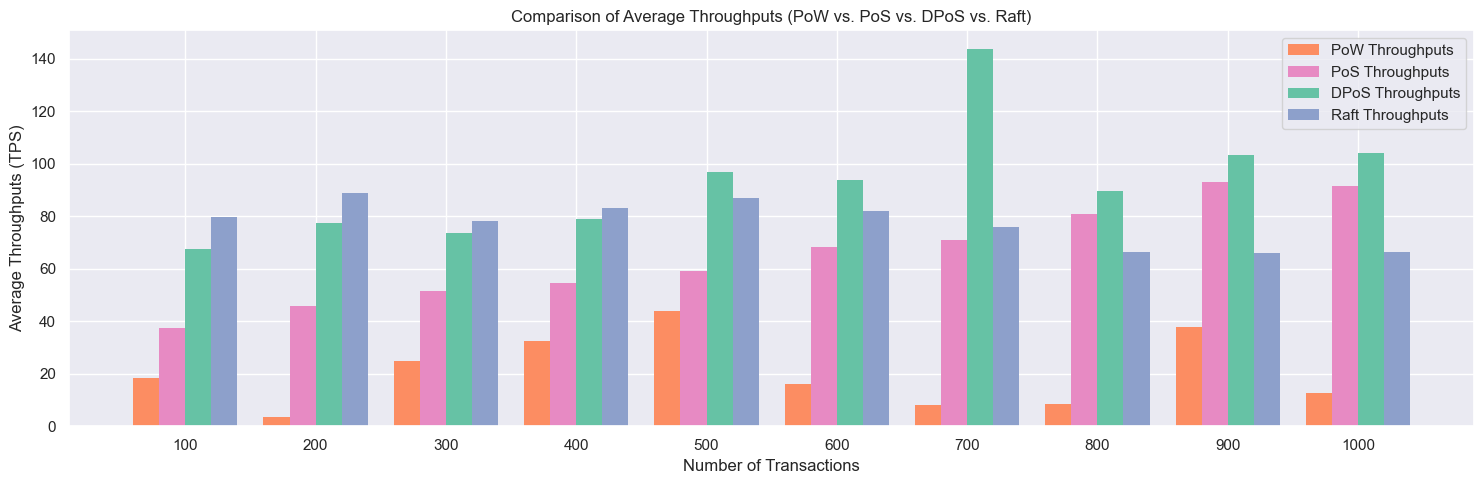

In [20]:
# To make the visualization more understandable.
colors = sns.color_palette('Set2', n_colors=4)
num_transactions = list(throughputs_pow.keys())
pow_throughputs_values = list(throughputs_pow.values())
pos_throughputs_values = list(throughputs_pos.values())
dpos_throughputs_values = list(throughputs_dpos.values())
raft_throughputs_values = list(raft_throughputs.values())

width = 0.2
fig, ax = plt.subplots(figsize=(15, 5))

x = np.arange(len(num_transactions))
bar1 = ax.bar(x - 1.5 * width, pow_throughputs_values, width, label='PoW Throughputs', color=colors[1], edgecolor='none', linewidth=0.7)
bar2 = ax.bar(x - 0.5 * width, pos_throughputs_values, width, label='PoS Throughputs', color=colors[3], edgecolor='none', linewidth=0.7)
bar3 = ax.bar(x + 0.5 * width, dpos_throughputs_values, width, label='DPoS Throughputs', color=colors[0], edgecolor='none', linewidth=0.7)
bar4 = ax.bar(x + 1.5 * width, raft_throughputs_values, width, label='Raft Throughputs', color=colors[2], edgecolor='none', linewidth=0.7)

ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Average Throughputs (TPS)')
ax.set_title('Comparison of Average Throughputs (PoW vs. PoS vs. DPoS vs. Raft)')
ax.set_xticks(x)
ax.set_xticklabels(num_transactions)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig('Comparision of Average Throughput_pow_pos_dpos_raft.png', dpi=300)
plt.show()


{100: 18.4483688737788}
{100: 18.4483688737788, 200: 3.3669171688754553}
{100: 18.4483688737788, 200: 3.3669171688754553, 300: 24.7578283578893}
{100: 18.4483688737788, 200: 3.3669171688754553, 300: 24.7578283578893, 400: 32.60539713919649}
{100: 18.4483688737788, 200: 3.3669171688754553, 300: 24.7578283578893, 400: 32.60539713919649, 500: 43.8595762911521}
{100: 18.4483688737788, 200: 3.3669171688754553, 300: 24.7578283578893, 400: 32.60539713919649, 500: 43.8595762911521, 600: 15.992778224478444}
{100: 18.4483688737788, 200: 3.3669171688754553, 300: 24.7578283578893, 400: 32.60539713919649, 500: 43.8595762911521, 600: 15.992778224478444, 700: 8.12645796247708}
{100: 18.4483688737788, 200: 3.3669171688754553, 300: 24.7578283578893, 400: 32.60539713919649, 500: 43.8595762911521, 600: 15.992778224478444, 700: 8.12645796247708, 800: 8.503712703223261}
{100: 18.4483688737788, 200: 3.3669171688754553, 300: 24.7578283578893, 400: 32.60539713919649, 500: 43.8595762911521, 600: 15.99277822447

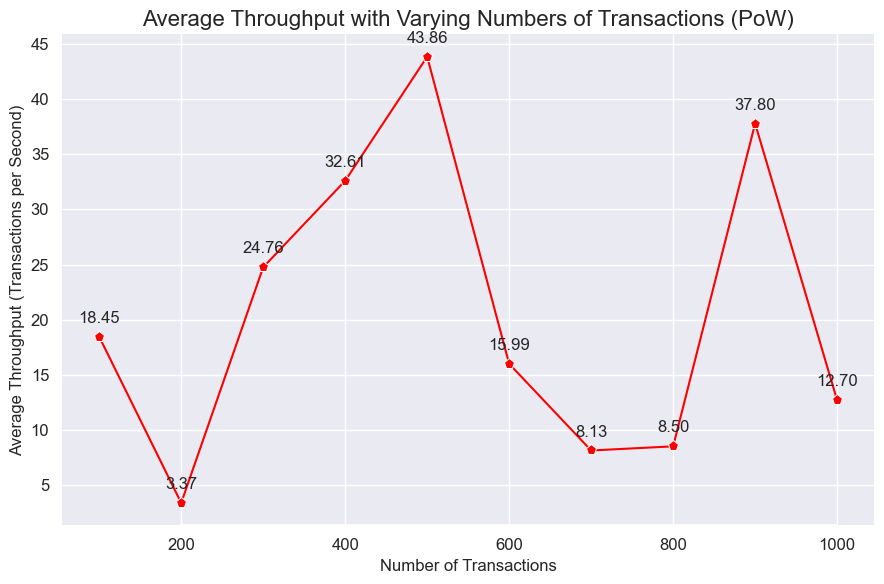

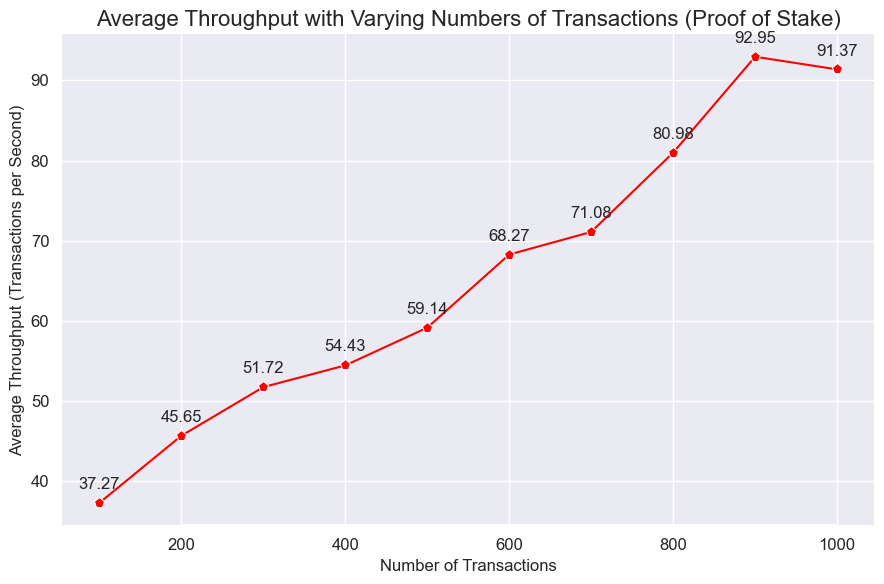

{100: 67.73683321441756}
{100: 67.73683321441756, 200: 77.29288128690507}
{100: 67.73683321441756, 200: 77.29288128690507, 300: 73.60787396240865}
{100: 67.73683321441756, 200: 77.29288128690507, 300: 73.60787396240865, 400: 78.96766208319349}
{100: 67.73683321441756, 200: 77.29288128690507, 300: 73.60787396240865, 400: 78.96766208319349, 500: 96.82973252413493}
{100: 67.73683321441756, 200: 77.29288128690507, 300: 73.60787396240865, 400: 78.96766208319349, 500: 96.82973252413493, 600: 93.91672425012013}
{100: 67.73683321441756, 200: 77.29288128690507, 300: 73.60787396240865, 400: 78.96766208319349, 500: 96.82973252413493, 600: 93.91672425012013, 700: 143.66893029063178}
{100: 67.73683321441756, 200: 77.29288128690507, 300: 73.60787396240865, 400: 78.96766208319349, 500: 96.82973252413493, 600: 93.91672425012013, 700: 143.66893029063178, 800: 89.74486964520902}
{100: 67.73683321441756, 200: 77.29288128690507, 300: 73.60787396240865, 400: 78.96766208319349, 500: 96.82973252413493, 600: 

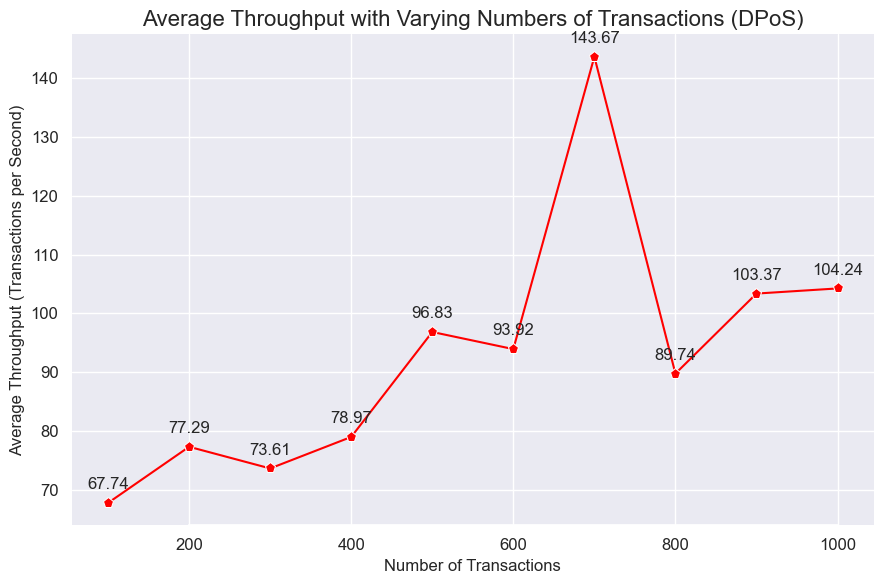

Starting transaction loop for 100 transactions...
Transaction loop for 100 transactions completed in 1.26 seconds.
{100: 79.6205522312071}
Starting transaction loop for 200 transactions...
Transaction loop for 200 transactions completed in 2.25 seconds.
{100: 79.6205522312071, 200: 89.00288241065317}
Starting transaction loop for 300 transactions...
Transaction loop for 300 transactions completed in 3.84 seconds.
{100: 79.6205522312071, 200: 89.00288241065317, 300: 78.12093227240935}
Starting transaction loop for 400 transactions...
Transaction loop for 400 transactions completed in 4.80 seconds.
{100: 79.6205522312071, 200: 89.00288241065317, 300: 78.12093227240935, 400: 83.28214701857277}
Starting transaction loop for 500 transactions...
Transaction loop for 500 transactions completed in 5.75 seconds.
{100: 79.6205522312071, 200: 89.00288241065317, 300: 78.12093227240935, 400: 83.28214701857277, 500: 86.88792936544051}
Starting transaction loop for 600 transactions...
Transaction loo

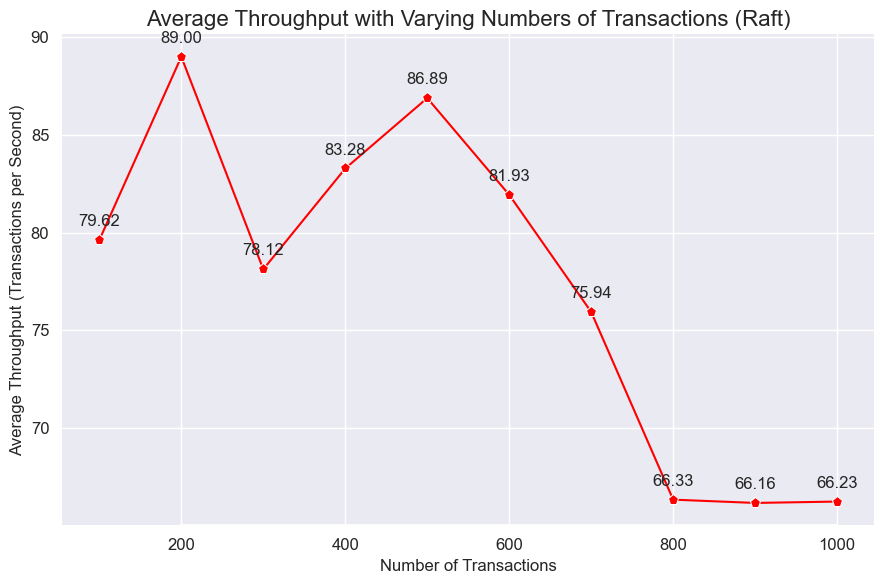

pow_latencies: {100: 0.06589932918548584, 500: 0.013270764827728272, 1000: 0.006511737823486328, 1500: 0.004238797982533773, 2000: 0.0030346473455429078}
pos_latencies: {100: 0.0031123971939086914, 500: 0.00019973278045654297, 1000: 8.153009414672851e-05, 1500: 3.1312147776285804e-05, 2000: 2.2785782814025878e-05}
dpos_latencies: {100: 0.0013640618324279785, 500: 0.00026784420013427736, 1000: 0.0001417233943939209, 1500: 4.317426681518555e-05, 2000: 3.0788421630859374e-05}
raft_latencies: {100: 0.25155784130096437, 500: 0.05069574403762817, 1000: 0.025296438932418824, 1500: 0.016825906753540038, 2000: 0.01263624656200409}


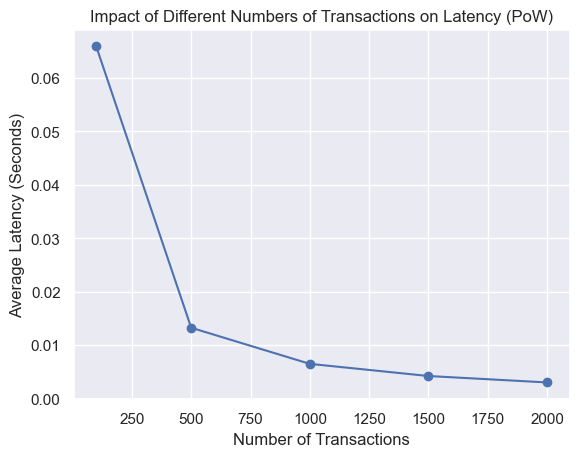

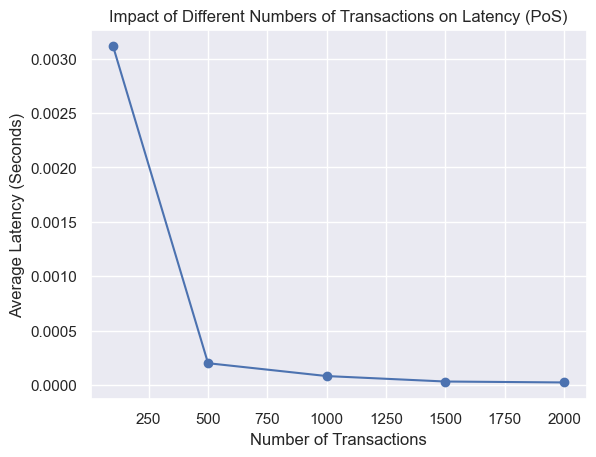

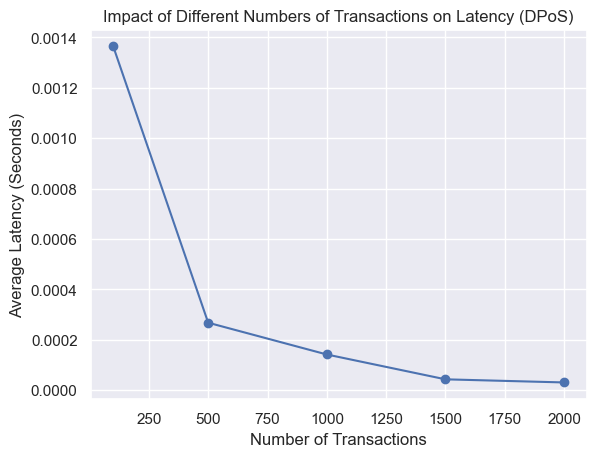

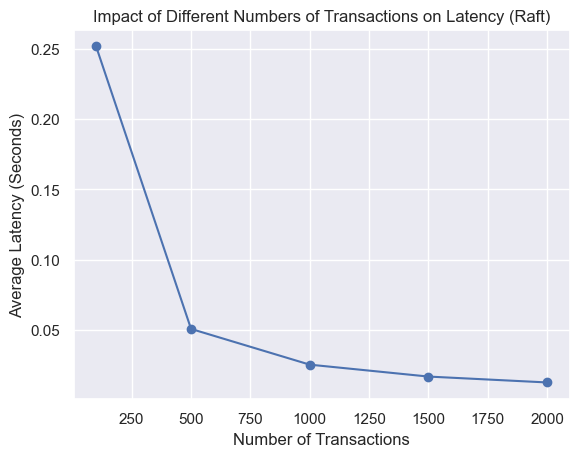

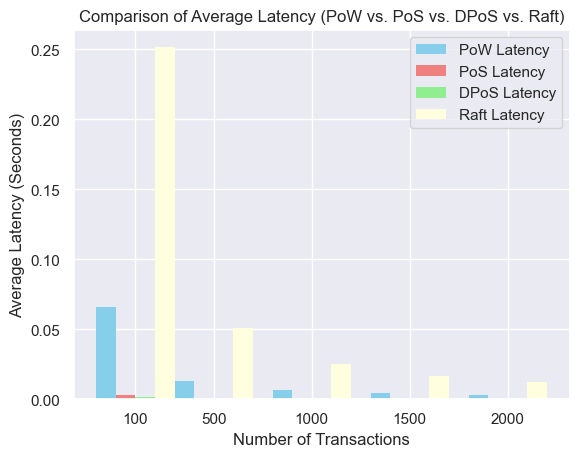

Simulating Raft with 5 nodes...
Simulation with 5 nodes completed in 25.42 seconds.
Simulating Raft with 10 nodes...
Simulation with 10 nodes completed in 50.76 seconds.
Simulating Raft with 15 nodes...
Simulation with 15 nodes completed in 75.84 seconds.
Simulating Raft with 20 nodes...
Simulation with 20 nodes completed in 100.84 seconds.
Simulating Raft with 25 nodes...
Simulation with 25 nodes completed in 126.37 seconds.
Simulating Raft with 30 nodes...
Simulation with 30 nodes completed in 152.05 seconds.
Simulating Raft with 35 nodes...
Simulation with 35 nodes completed in 176.95 seconds.
Simulating Raft with 40 nodes...
Simulation with 40 nodes completed in 202.19 seconds.


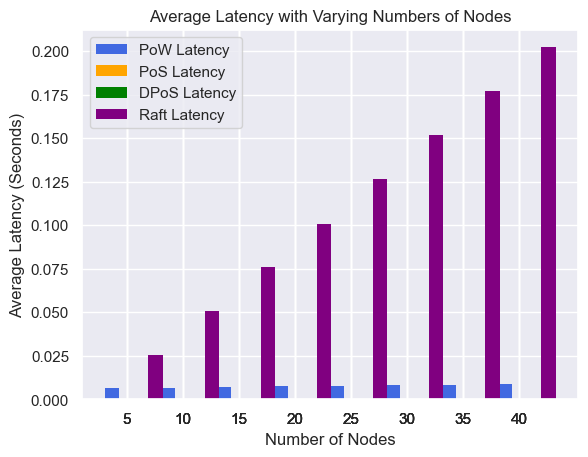

In [19]:
if __name__ == "__main__":
    throughputs_pow = simulate_pow_throughputs()
    visualize_pow_throughput(throughputs_pow)
    
    throughputs_pos = simulate_pos_throughputs()
    visualize_pos_throughput(throughputs_pos)
    
    throughputs_dpos = simulate_dpos_throughputs()
    visualize_dpos_throughput(throughputs_dpos)
    
    raft_throughputs = simulate_raft_throughputs()
    visualize_raft_throughput(raft_throughputs)
    
    simulate_latency_impact()
    
    num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
    pow_latencies = simulate_latency_with_nodes_pow(num_nodes)
    pos_latencies = simulate_latency_with_nodes_pos(num_nodes)
    dpos_latencies = simulate_latency_with_nodes_dpos(num_nodes)
    raft_latencies = simulate_latency_with_nodes_raft(num_nodes)
    
    visualize_latency_with_nodes(pow_latencies, pos_latencies, dpos_latencies, raft_latencies, num_nodes)


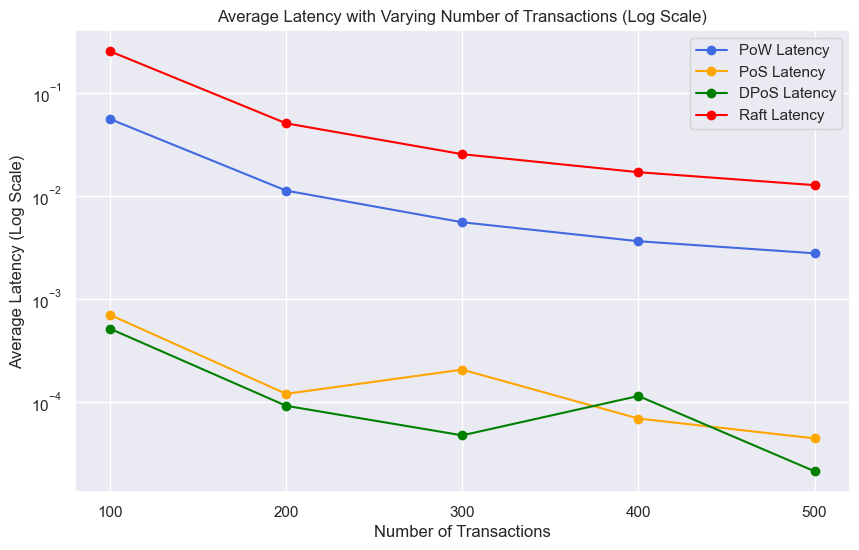

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data (replace with your actual data)
num_transactions = [100, 200, 300, 400, 500]
pow_latencies = {100: 0.05560929536819458, 500: 0.011211042404174804, 1000: 0.005520173788070679, 1500: 0.003613100369771322, 2000: 0.0027570225000381468}
pos_latencies = {100: 0.0006953501701354981, 500: 0.00011875152587890625, 1000: 0.00020401740074157715, 1500: 6.831471125284831e-05, 2000: 4.3844223022460934e-05}
dpos_latencies = {100: 0.0005100798606872558, 500: 9.080696105957032e-05, 1000: 4.690051078796387e-05, 1500: 0.00011315504709879558, 2000: 2.0999431610107423e-05}
raft_latencies = {100: 0.25356934070587156, 500: 0.050534528732299806, 1000: 0.02533510112762451, 1500: 0.01693139664332072, 2000: 0.012669727802276612}

# Plot data on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.semilogy(num_transactions, list(pow_latencies.values()), marker='o', label='PoW Latency', color='royalblue')
plt.semilogy(num_transactions, list(pos_latencies.values()), marker='o', label='PoS Latency', color='orange')
plt.semilogy(num_transactions, list(dpos_latencies.values()), marker='o', label='DPoS Latency', color='green')
plt.semilogy(num_transactions, list(raft_latencies.values()), marker='o', label='Raft Latency', color='red')

# Set labels and title
plt.xlabel('Number of Transactions')
plt.ylabel('Average Latency (Log Scale)')
plt.title('Average Latency with Varying Number of Transactions (Log Scale)')
plt.xticks(num_transactions)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
